## First goal: getting a filtration from data using existing tools

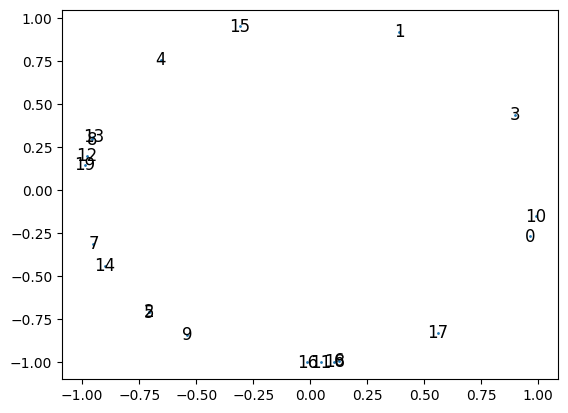

In [1]:
import numpy as np
import gudhi as gd
import tadasets
import matplotlib.pyplot as plt
from ripser import ripser
sphere = tadasets.dsphere(n=20, d=1, noise=0, seed=42)
plt.scatter(sphere[:,0], sphere[:,1], s=1)
for i, (x, y) in enumerate(sphere):
    plt.text(x, y, str(i), fontsize=12, ha='center', va='center')

points = np.asarray([[0,0], [1, 0], [0,2]])
rips = gd.RipsComplex(points=sphere, max_edge_length=0.8)
st = rips.create_simplex_tree(max_dimension=2)
st.compute_persistence()
filtration = list(st.get_filtration())


In [2]:
import numpy as np

# For now, this is slow. Probably want to move this to the Rust component, and pass the simplices directly at some point.
def compute_boundary_matrices(simplices):
    """
    Compute boundary matrices for a simplicial complex.

    Parameters:
    simplices (dict): Dictionary where keys are dimensions (int) and values are lists of tuples representing simplices.

    Returns:
    dict: Dictionary where keys are dimensions and values are NumPy arrays representing boundary matrices.
    """

    # Determine the maximum dimension
    max_dim = max(simplices.keys())

    # Create index mappings for each dimension
    index_maps = {
        dim: {simplex: idx for idx, simplex in enumerate(simplices[dim])}
        for dim in simplices
    }

    # Compute boundary matrices
    boundary_matrices = {}
    for dim in range(1, max_dim + 1):
        higher_simplices = simplices.get(dim, [])
        lower_simplices = simplices.get(dim - 1, [])
        lower_index_map = index_maps.get(dim - 1, {})

        rows = [] 
        cols = []
        data = []
        # for each of the higher simplices
        for col, simplex in enumerate(higher_simplices):
            # for each of the vertices of the simplex
            for i, _ in enumerate(simplex):
                # get face missing this index
                face = simplex[:i] + simplex[i+1:]
                # since this is a simplicial complex, the face is in the lower simplices
                row = lower_index_map.get(face)
                rows.append(row)
                cols.append(col)
                data.append((-1) ** i)
        
        # create sparse matrix
        n_rows = len(lower_simplices)
        n_cols = len(higher_simplices)
        boundary_matrices[dim] = {"n_rows": n_rows, "n_cols": n_cols, "data": np.asarray(data, dtype=np.float64), "rows": np.asarray(rows, dtype=np.int64), "cols": np.asarray(cols, dtype=np.int64)}

    return boundary_matrices

In [3]:
from collections import defaultdict
# 1. Create the global boundary map
simplices_by_dim = defaultdict(list)
simplices_by_dim_only_filt = defaultdict(list)
for (simplex, filt_value) in filtration:
    dim = len(simplex) - 1
    simplices_by_dim[dim].append(tuple(sorted(simplex)))
    simplices_by_dim_only_filt[dim].append(filt_value)
b = compute_boundary_matrices(simplices_by_dim)
b

{1: {'n_rows': 20,
  'n_cols': 51,
  'data': array([ 1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1.,
         -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,
          1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1.,
         -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,
          1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1.,
         -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,
          1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1.,
         -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.]),
  'rows': array([ 5,  2, 13,  8, 18,  6, 19, 12, 18, 11, 16, 11, 11,  6, 12,  8, 13,
         12, 10,  0, 18, 16, 14,  7, 16,  6, 19,  8, 19, 13,  9,  5,  9,  2,
         14,  2, 14,  5, 15,  4, 19,  7, 17,  6,  7,  2,  7,  5, 18, 17, 12,
          7, 13,  4, 17, 11, 14,  9,  8,  4, 16,  9, 19, 14, 10,  3, 17, 16,
          8,  7, 11,  9, 13,  7, 14, 12, 12,  4, 18,  9, 

In [4]:
import bisect
def max_index(lst, b):
    # Find the insertion point for b to the right
    idx = bisect.bisect_right(lst, b)
    return idx 
unique_filtration_values = sorted(list(set([f for (_, f) in filtration])))
# print(simplices_by_dim_only_filt)
# For each filtration value, get indices for the boundary map at that filtration value
boundary_maps_index_dict = {filt_index: 
                                {  
                                    key : max_index(filt_values, filt_value)
                                    for key, filt_values in simplices_by_dim_only_filt.items()
                                } 
                                for (filt_index, filt_value) in enumerate(unique_filtration_values)
                            }

print(boundary_maps_index_dict)

{0: {0: 20, 1: 0, 2: 0}, 1: {0: 20, 1: 1, 2: 0}, 2: {0: 20, 1: 2, 2: 0}, 3: {0: 20, 1: 3, 2: 0}, 4: {0: 20, 1: 4, 2: 0}, 5: {0: 20, 1: 5, 2: 0}, 6: {0: 20, 1: 6, 2: 0}, 7: {0: 20, 1: 7, 2: 1}, 8: {0: 20, 1: 8, 2: 1}, 9: {0: 20, 1: 9, 2: 2}, 10: {0: 20, 1: 10, 2: 2}, 11: {0: 20, 1: 11, 2: 3}, 12: {0: 20, 1: 12, 2: 3}, 13: {0: 20, 1: 13, 2: 5}, 14: {0: 20, 1: 14, 2: 6}, 15: {0: 20, 1: 15, 2: 8}, 16: {0: 20, 1: 16, 2: 8}, 17: {0: 20, 1: 17, 2: 9}, 18: {0: 20, 1: 18, 2: 9}, 19: {0: 20, 1: 19, 2: 10}, 20: {0: 20, 1: 20, 2: 10}, 21: {0: 20, 1: 21, 2: 10}, 22: {0: 20, 1: 22, 2: 10}, 23: {0: 20, 1: 23, 2: 11}, 24: {0: 20, 1: 24, 2: 13}, 25: {0: 20, 1: 25, 2: 14}, 26: {0: 20, 1: 26, 2: 15}, 27: {0: 20, 1: 27, 2: 15}, 28: {0: 20, 1: 28, 2: 17}, 29: {0: 20, 1: 29, 2: 19}, 30: {0: 20, 1: 30, 2: 20}, 31: {0: 20, 1: 31, 2: 20}, 32: {0: 20, 1: 32, 2: 21}, 33: {0: 20, 1: 33, 2: 21}, 34: {0: 20, 1: 34, 2: 24}, 35: {0: 20, 1: 35, 2: 26}, 36: {0: 20, 1: 36, 2: 27}, 37: {0: 20, 1: 37, 2: 30}, 38: {0: 20, 

## Second goal: implementation of the Schur's complement Persistent Laplacian solver for a filtration

In [5]:
import numpy as np
import persistent_laplacians

boundary_matrices = compute_boundary_matrices(simplices_by_dim)
result = persistent_laplacians.process_tda(
    boundary_matrices,
    boundary_maps_index_dict
)
print("Rust returned:", result)

Rust returned: {1: {(13, 45): 0, (34, 44): 0, (13, 37): 0, (14, 19): 0, (13, 15): 0, (9, 49): 0, (1, 12): 0, (18, 37): 0, (5, 13): 0, (3, 8): 0, (11, 23): 0, (21, 40): 0, (10, 22): 0, (9, 11): 0, (3, 7): 0, (17, 38): 0, (19, 21): 0, (1, 3): 0, (17, 51): 0, (8, 48): 0, (3, 33): 0, (39, 43): 0, (2, 12): 0, (29, 32): 0, (4, 34): 0, (15, 46): 0, (32, 46): 0, (10, 34): 0, (2, 30): 0, (25, 45): 0, (22, 45): 0, (14, 37): 0, (3, 47): 0, (39, 44): 0, (1, 34): 0, (7, 33): 0, (18, 39): 0, (9, 48): 0, (3, 44): 0, (25, 42): 0, (28, 50): 0, (24, 39): 0, (3, 26): 0, (9, 22): 0, (9, 23): 0, (23, 46): 0, (2, 18): 0, (0, 18): 0, (26, 40): 0, (26, 28): 0, (25, 51): 0, (5, 18): 0, (32, 38): 0, (13, 28): 0, (3, 43): 0, (17, 50): 0, (19, 49): 0, (47, 48): 1, (7, 34): 0, (9, 36): 0, (4, 5): 0, (44, 45): 0, (14, 35): 0, (27, 48): 0, (10, 29): 0, (1, 19): 0, (7, 19): 0, (4, 7): 0, (24, 28): 0, (37, 49): 0, (32, 50): 0, (42, 49): 0, (22, 47): 0, (38, 44): 0, (15, 31): 0, (9, 33): 0, (39, 51): 0, (31, 44): 0, (1


thread '<unnamed>' panicked at /Users/marcelmasque/.cargo/registry/src/index.crates.io-1949cf8c6b5b557f/lanczos-0.2.0/src/lib.rs:177:81:
called `Option::unwrap()` on a `None` value
note: run with `RUST_BACKTRACE=1` environment variable to display a backtrace

thread '<unnamed>' panicked at /Users/marcelmasque/.cargo/registry/src/index.crates.io-1949cf8c6b5b557f/lanczos-0.2.0/src/lib.rs:177:81:
called `Option::unwrap()` on a `None` value

thread '<unnamed>' panicked at /Users/marcelmasque/.cargo/registry/src/index.crates.io-1949cf8c6b5b557f/lanczos-0.2.0/src/lib.rs:177:81:
called `Option::unwrap()` on a `None` value

thread '<unnamed>' panicked at /Users/marcelmasque/.cargo/registry/src/index.crates.io-1949cf8c6b5b557f/lanczos-0.2.0/src/lib.rs:177:81:
called `Option::unwrap()` on a `None` value

thread '<unnamed>' panicked at /Users/marcelmasque/.cargo/registry/src/index.crates.io-1949cf8c6b5b557f/lanczos-0.2.0/src/lib.rs:177:81:
called `Option::unwrap()` on a `None` value

thread '<un

In [12]:
{k: v for k, v in result[1].items() if v >= 1}

{(47, 48): 1,
 (50, 51): 1,
 (48, 49): 1,
 (46, 48): 1,
 (48, 51): 1,
 (49, 50): 1,
 (48, 50): 1,
 (46, 49): 1,
 (46, 51): 1,
 (46, 50): 1,
 (49, 51): 1,
 (47, 51): 1,
 (47, 49): 1,
 (47, 50): 1,
 (46, 47): 1}

In [ ]:
import gudhi
rips_complex = gudhi.RipsComplex(points=points, max_edge_length=0.5)
simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)

# Compute persistence
simplex_tree.compute_persistence()



([0], 0.0)
([1], 0.0)
([2], 0.0)
